# Calculate gradient wind vectors from SSH and store in NetCDF

In [1]:
from IPython.display import HTML

%run ../../_setup.py

from netCDF4 import Dataset, num2date
from xarray import open_dataset
from OceanPy.netcdf import createNetCDF
from shutil import copyfile

import pyproj
import numpy as np
from scipy.interpolate import griddata
from OceanPy.kinematics import gradient_wind_from_ssh

import matplotlib.pyplot as plt

from datetime import datetime
from pandas import to_datetime
from OceanPy.animations import play2D
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

In [2]:
# load ctd data
input_file_ctd = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd.nc')
ctd = Dataset(input_file_ctd, 'r')

# load altimetry data from selection of data
# west = 135
# south = -53.4
# east = 149
# north = -47

west = 137
south = -52.4
east = 147
north = -48
input_file_sel = os.path.join(datadir, 'external', 'ssh', 'processed', 
                              'rep_allsat_phy_l4_%s_%s_%s_%s_199803.nc' 
                              %(west, int(south), east, int(north)))

In [3]:
# output files
output_file_gw = os.path.join(datadir, 'external', 'ssh', 'processed', 
                              'rep_allsat_phy_l4_%s_%s_%s_%s_199803_gw.nc'
                              %(west, int(south), east, int(north)))
output_file_gw_ctd = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_gw_ctd.nc')

## calculate gradient wind with function in OceanPy and store in netCDF

In [4]:
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

group = 'GW'

if os.path.isfile(output_file_gw):
    print('Output file %s already exists.' %os.path.basename(output_file_gw))
else: 
    gw = gradient_wind_from_ssh(input_file_sel, output_file=output_file_gw, group=group, smooth=True, transform=UTM54)
    print('Output file %s saved in: %s.' %(os.path.basename(output_file_gw), os.path.dirname(output_file_gw)))



Output file rep_allsat_phy_l4_137_-52_147_-48_199803_gw.nc, copied from input file rep_allsat_phy_l4_137_-52_147_-48_199803.nc.


/home/janjaapmeijer/Checkouts/OceanPy/kinematics.py:265: RuntimeWarning: invalid value encountered in sqrt
  root = np.sqrt(((fcor**2 * Rcurv**2) / 4) + (fcor * Rcurv * Vgeos))


New variables ugeos, vgeos, ori, Vgrad, Vgeos, ugrad, vgrad, stored in group GW, of the output file.
Output file rep_allsat_phy_l4_137_-52_147_-48_199803_gw.nc saved in: /home/janjaapmeijer/Checkouts/phd/data/external/ssh/processed.


## interpolate gradient wind velocities to CTD locations

In [5]:
gw = open_dataset(output_file_gw, group=group)

In [6]:
# CTD dimensions
lon_ctd, lat_ctd = ctd['lon'][:, 0], ctd['lat'][:, 0]
time = num2date(ctd['time'][:, 0], ctd['time'].units)
time_str = [t.strftime('%Y-%m-%d') for t in time]
time_voy = slice('1998-03-10', '1998-03-28')

# SSH dimensions
time_str_ssh = np.datetime_as_string(gw.time, unit='D')

In [7]:
group = 'CTD'

dimensions = {
    'time': time.size,
    'latitude': lat_ctd.size,
    'longitude': lon_ctd.size
}

variables = {
    'ugeos': ('surface_geostrophic_eastward_sea_water_velocity', 'f8', 'time'),
    'vgeos': ('surface_geostrophic_northward_sea_water_velocity', 'f8', 'time'),
    'ugrad': ('surface_eastward_sea_water_velocity', 'f8', 'time'),
    'vgrad': ('surface_northward_sea_water_velocity', 'f8', 'time'),
    'ori': ('sea_water_velocity_to_direction', 'f8', 'time')
}

In [8]:
# interpolate geostrophic and gradient wind velocities to CTD locations
loni, lati = np.meshgrid(gw.longitude, gw.latitude)
points = np.array((loni.flatten(), lati.flatten())).T

new_variables = {}
for var in variables.keys():
    data = np.ma.masked_all((time.size,))
    for i in range(2, data.size):
        values = gw[var].sel(time=time_str[i]).values.flatten()
        data[i,] = griddata(points, values, (lon_ctd[i], lat_ctd[i]))
    new_variables['/%s/%s' %(group, var)] = variables[var] + (data,)

# # ageostrophic components at CTD locations    
# gw_ctd['uag'] = gw_ctd['ugrad'] - gw_ctd['ugeos']
# gw_ctd['vag'] = gw_ctd['vgrad'] - gw_ctd['vgeos']

# # geostrophic, ageostrophic and gradient wind speed and CTD locations
# gw_ctd['Vgrad'] = np.sqrt(gw_ctd['ugrad']**2 + gw_ctd['vgrad']**2)
# gw_ctd['Vgeos'] = np.sqrt(gw_ctd['ugeos']**2 + gw_ctd['vgeos']**2)
# gw_ctd['Vag'] = np.sqrt(gw_ctd['uag']**2 + gw_ctd['vag']**2)

# gw_ctd['dV'] = ((gw_ctd['Vgrad'] - gw_ctd['Vgeos']) / gw_ctd['Vgeos']) * 100
# TODO: Vag should be the same as Vgrad-Vgeos --> (gw_ctd['Vag'] / gw_ctd['Vgeos']) * 100

## store gradient wind variables at CTD locations in netCDF

In [9]:
# load file and variables
if output_file_gw_ctd is not None and os.path.isfile(output_file_gw_ctd):
    print('Output file %s already exists.' %os.path.basename(output_file_gw_ctd))
    gw_ctd = open_dataset(output_file_gw_ctd)
elif output_file_gw_ctd is not None and not os.path.isfile(output_file_gw_ctd):
    copyfile(output_file_gw, output_file_gw_ctd)
    print('Output file %s, copied from input file %s.'
          %(os.path.basename(output_file_gw_ctd), os.path.basename(output_file_gw)))
    gw_ctd = createNetCDF(output_file_gw_ctd)

Output file rep_allsat_phy_l4_ss9802_gw_ctd.nc already exists.


In [10]:
try: 
    # create group
    dsgroup = gw_ctd.dataset.createGroup(group)

    # # create dimensions and coordinates
    for name, size in dimensions.items():

        dsgroup.createDimension(name, size)

        if name in dimensions:
            if name == 'time':
                values = time
            elif name == 'longitude':
                values = np.ma.masked_invalid(lon_ctd)
            elif name == 'latitude':
                values = np.ma.masked_invalid(lat_ctd)
            else:
                values = ctd[name][:]

            new_variables['/%s/%s' %(group, name)] = (name, 'f8', name, values)

    # # create variables
    gw_ctd.create_vars(new_variables)

    gw_ctd.close()
    
except AttributeError:
    print('Output file already exists. Nothing is added to the netCDF file.')

Output file already exists. Nothing is added to the netCDF file.


## open gradient wind variables and check data

In [11]:
ssh = open_dataset(output_file_gw)
gw = open_dataset(output_file_gw, group='GW')
gw_ctd = open_dataset(output_file_gw_ctd, group='CTD')

# ageostrophic components
uag = gw.ugrad - gw.ugeos
vag = gw.vgrad - gw.vgeos

uag_ctd = gw_ctd.ugrad - gw_ctd.ugeos
vag_ctd = gw_ctd.vgrad - gw_ctd.vgeos

In [12]:
mask = np.array([datetime(1998, 3, 12) <= to_datetime(t) <= datetime(1998, 3, 28) for t in ssh.time.data])
bounds = np.linspace(-0.75, 0.75, 21)

anim = play2D(ssh.longitude, ssh.latitude, z=ssh.adt.data, time=ssh.time.data, 
              u=uag.data, v=vag.data, mask=mask, cmap=plt.cm.jet, 
              type='quiver', bounds=bounds, step=2, interval=400, 
              save=False, savepath=os.path.join(outdir, 'ss9802'))
display_animation(anim)

Text(0.5, 1.0, 'Ageostrophic velocity vectors on SSH contours')

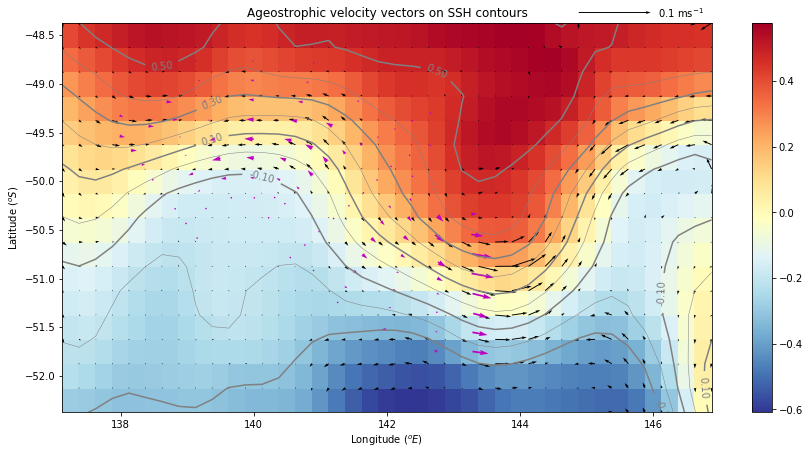

In [13]:
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
fig.tight_layout()

pcol = ax.pcolor(ssh.longitude, ssh.latitude, ssh.adt.sel(time=time_voy).mean('time'), cmap=plt.cm.RdYlBu_r)
fig.colorbar(pcol, ax=ax)

bounds = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
ct = ax.contour(ssh.longitude, ssh.latitude, ssh.adt.sel(time=time_voy).mean('time'), bounds, 
                     colors='gray', linestyles='solid', linewidths=0.5)

quiv = ax.quiver(ssh.longitude, ssh.latitude, uag.sel(time=time_voy).mean('time'), vag.sel(time=time_voy).mean('time'), 
                 units='inches', scale=0.1, width=1.1e-3*fig.get_size_inches()[0], color='k')
qk = plt.quiverkey(quiv, .72, 0.99, 0.1, r'0.1 ms$^{-1}$', labelpos='E', coordinates='figure')

quiv = ax.quiver(gw_ctd.longitude[2:], gw_ctd.latitude[2:], uag_ctd[2:], vag_ctd[2:], 
                 units='inches', scale=0.1, width=2e-3*fig.get_size_inches()[0], color='m')

for ib, b in enumerate(bounds):
    if b in bounds[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
ax.clabel(ct, bounds[0::2], inline=1, fmt='%.2f')

# plot labels
ax.set_xlabel(r'Longitude ($^oE$)')
ax.set_ylabel(r'Latitude ($^oS$)')
ax.set_title('Ageostrophic velocity vectors on SSH contours')